In [1]:
'''
Research Project: Gaussian Differential Privacy

Code Implementation: GDP with Machine Learning

---------------------------------------------------------------------------------------------------------------------------

Description: 

Parameters: sensitivity=1, delta=1e-5, epsilon=0.1

Note: In our research, we decided to focus on values of epsilon that epsilon ∈ (0, 1) which are e=0.1, e=0.3, e=0.5, e=0.9

For the third topic in the research project, we work on independent variables of Heart Disease data to study how the 4 
different privacy budget epsilon ∈ (0, 1) influence 7 ML models' accuracy. 

After the code implementation of the third topic, We can:
(1) Try to gain insights into the utility of different privacy 
(2) Identify which models are most suitable for analyzing data with different levels of privacy protection

---------------------------------------------------------------------------------------------------------------------------
In the code implementation of GDP with Machine Learning, we aim to examine the impact of the different budgets on 7 
classification models by implementing it on:
Lab 2.1 continuous independent variables with e=0.1, e=0.3, e=0.5, e=0.9
Lab 2.2 categorical independent variables (excluding dummy variables and its corresponding features) with e=0.1, 
        e=0.3, e=0.5, e=0.9

And then, examin the differences among accuracies via two intuitive and standard rules: 

Rule 1. After applying GDP, if the differences in accuracies are changed within 20% and accuracies are still greater than 80%, 
we consider the models trained on noise data still has statistical information to provide meaningful insights.

Rule 2. After applying GDP, if the differences in accuracies are changed by more than 20%, we consider the models trained on 
noise data do not have statistical information to provide meaningful insights. Healthcare statisticians cannot make use of it 
to make decisions.

'''

"\nYuanyuan Sun | cs528, Spring 2023 | College of Computing, Illinois Tech\n\nResearch Project: Gaussian Differential Privacy\n\nCode Implementation: GDP with Machine Learning\n\n---------------------------------------------------------------------------------------------------------------------------\n\nDescription: \n\nParameters: sensitivity=1, delta=1e-5, epsilon=0.1\n\nNote: In our research, we decided to focus on values of epsilon that epsilon ∈ (0, 1) which are e=0.1, e=0.3, e=0.5, e=0.9\n\nFor the third topic in the research project, we work on independent variables of Heart Disease data to study how the 4 \ndifferent privacy budget epsilon ∈ (0, 1) influence 7 ML models' accuracy. \n\nAfter the code implementation of the third topic, We can:\n(1) Try to gain insights into the utility of different privacy \n(2) Identify which models are most suitable for analyzing data with different levels of privacy protection\n\n---------------------------------------------------------------

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import yellowbrick
import pickle
from tabulate import tabulate
from matplotlib.collections import PathCollection
from statsmodels.graphics.gofplots import qqplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
from yellowbrick.classifier import PrecisionRecallCurve, ROCAUC, ConfusionMatrix
from yellowbrick.style import set_palette
from yellowbrick.model_selection import LearningCurve, FeatureImportances
from yellowbrick.contrib.wrapper import wrap

# --- Libraries Settings ---
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.dpi']=100
set_palette('dark')

# --- Create List of Color Palletes ---
red_grad = ['#FF0000', '#BF0000', '#800000', '#400000', '#000000']
pink_grad = ['#8A0030', '#BA1141', '#FF5C8A', '#FF99B9', '#FFDEEB']
purple_grad = ['#4C0028', '#7F0043', '#8E004C', '#A80059', '#C10067']
color_mix = ['#F38BB2', '#FFB9CF', '#FFD7D7', '#F17881', '#E7525B']
black_grad = ['#100C07', '#3E3B39', '#6D6A6A', '#9B9A9C', '#CAC9CD']

In [3]:
# --- Importing Dataset ---
df = pd.read_csv("datasets/heart_original.csv")

# --- Reading Dataset ---
df.head().style.background_gradient(cmap='Reds').set_properties(**{'font-family': 'Segoe UI'}).hide_index()

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
52,1,0,125,212,0,1,168,0,1.000000,2,2,3,0
53,1,0,140,203,1,0,155,1,3.100000,0,0,3,0
70,1,0,145,174,0,1,125,1,2.600000,0,0,3,0
61,1,0,148,203,0,1,161,0,0.000000,2,1,3,0
62,0,0,138,294,1,1,106,0,1.900000,1,3,2,0


In [4]:
# --- Print Dataset Info ---
print('\033[1m'+'.: Dataset Info :.'+'\033[0m')
print('*' * 30)
print('Total Rows:'+'\033[1m', df.shape[0])
print('\033[0m'+'Total Columns:'+'\033[1m', df.shape[1])
print('\033[0m'+'*' * 30)
print('\n')

# --- Print Dataset Detail ---
print('\033[1m'+'.: Dataset Details :.'+'\033[0m')
print('*' * 30)
df.info(memory_usage = False)

.: Dataset Info :.
******************************
Total Rows: 1025
Total Columns: 14
******************************


.: Dataset Details :.
******************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)

In [5]:
'''
Create 1 new data sets: df_v2;

How many people are the oldest in the processed.cleveland data set?
What is the oldest age?
'''
df_v1 = df

# df_v2 -----------------------------------------------------------------------------------------------------
# Find the maximum age
max_age = df_v1['age'].max()

# Count the number of people with the maximum age
num_oldest = df_v1[df_v1['age'] == max_age]['age'].count()

# Output the results
print("There are {} people who are the oldest in the dataset, with an age of {}.".format(num_oldest, max_age))

#-------------------------------------
# Find the index of the oldest individual
oldest_idx = df_v1['age'].idxmax()

# Remove the row with the oldest individual and create a new DataFrame
df_v2 = df_v1.drop(oldest_idx)

# Reset the index of the new DataFrame
df_v2 = df_v2.reset_index(drop=True)

# Comparison -----------------------------------------------------------------------------------------------------------------------
# Number of records in df_v1 and df_v2
num_records = [["df_v1", len(df_v1)], ["df_v2", len(df_v2)]]

# Output as table
print(tabulate(num_records, headers=["Dataset", "Number of Records"], tablefmt="grid"))

There are 3 people who are the oldest in the dataset, with an age of 77.
+-----------+---------------------+
| Dataset   |   Number of Records |
+===========+=====================+
| df_v1     |                1025 |
+-----------+---------------------+
| df_v2     |                1024 |
+-----------+---------------------+


In [6]:
'''
Since two data sets differ in one record, remove or add one record, the sensitivey for features are 1
'''
sensitivity = 1
epsilon = 0.1
delta = 1e-5
sigma = sensitivity / epsilon

# Compute the standard deviation of the Gaussian noise
std_dev = np.sqrt(2 * np.log(1.25 / delta)) * sensitivity / epsilon

# Gaussian noise 
noise = np.random.normal(loc=0, scale=std_dev)

df_v2['age'] = df_v2['age'] + noise
df_v2['trestbps'] = df_v2['trestbps'] + noise
df_v2['thalach'] = df_v2['thalach'] + noise
df_v2['oldpeak'] = df_v2['oldpeak'] + noise
df_v2['chol'] = df_v2['chol'] + noise

df_v2.head().style.background_gradient(cmap='Reds').set_properties(**{'font-family': 'Segoe UI'}).hide_index()

print("sigma = ", sigma)

sigma =  10.0


In [7]:
df2_continuous = df_v2[['age', 'trestbps', 'thalach', 'oldpeak', 'chol']]
#print(df2_continuous)
df1_continuous = df_v1[['age', 'trestbps', 'thalach', 'oldpeak', 'chol']]

print("After Applying GDP when e = 0.1:")
df2_continuous.head().style.background_gradient(cmap='Reds').set_properties(**{'font-family': 'Segoe UI'}).hide_index()


After Applying GDP when e = 0.1:


age,trestbps,thalach,oldpeak,chol
41.405108,114.405108,157.405108,-9.594892,201.405108
42.405108,129.405108,144.405108,-7.494892,192.405108
59.405108,134.405108,114.405108,-7.994892,163.405108
50.405108,137.405108,150.405108,-10.594892,192.405108
51.405108,127.405108,95.405108,-8.694892,283.405108


In [8]:
print("Original Continuous Data:")
df1_continuous.head().style.background_gradient(cmap='Reds').set_properties(**{'font-family': 'Segoe UI'}).hide_index()

Original Continuous Data:


age,trestbps,thalach,oldpeak,chol
52,125,168,1.000000,212
53,140,155,3.100000,203
70,145,125,2.600000,174
61,148,161,0.000000,203
62,138,106,1.900000,294


In [9]:
# calculate the difference
df_diff = df2_continuous.subtract(df1_continuous)

# print the result
print("When e = 0.1, the continuous features' values difference between the original data set and the noise data set")
df_diff.head().style.background_gradient(cmap='Reds').set_properties(**{'font-family': 'Segoe UI'}).hide_index()

When e = 0.1, the continuous features' values difference between the original data set and the noise data set


age,trestbps,thalach,oldpeak,chol
-10.594892,-10.594892,-10.594892,-10.594892,-10.594892
-10.594892,-10.594892,-10.594892,-10.594892,-10.594892
-10.594892,-10.594892,-10.594892,-10.594892,-10.594892
-10.594892,-10.594892,-10.594892,-10.594892,-10.594892
-10.594892,-10.594892,-10.594892,-10.594892,-10.594892


In [10]:
'''
Calculate the mean difference on each continuous features
'''
# calculate the mean difference on each continuous feature
mean_diff = df_diff.mean()

# print the result
print("When e = 0.1, the mean difference between the original and noise continuous features:")
# print(mean_diff)
mean_diff = df_diff.mean().to_frame(name='mean_diff')

mean_diff.style.background_gradient(cmap = "Reds_r")


When e = 0.1, the mean difference between the original and noise continuous features:


,mean_diff
age,-10.617353
trestbps,-10.599774
thalach,-10.642743
oldpeak,-10.593524
chol,-10.708173


In [11]:
'''
Calculate the varriance difference on each continuous features
'''
variance_diff = df2_continuous.var() - df1_continuous.var()
print("When e = 0.1, the variance difference between the original and noise continuous features:")
# print(variance_diff)
variance_diff = pd.DataFrame({'variance_diff': variance_diff})
variance_diff.style.background_gradient(cmap = "Reds_r")

When e = 0.1, the variance difference between the original and noise continuous features:


,variance_diff
age,-0.417799
trestbps,0.257163
thalach,0.354893
oldpeak,0.000226
chol,-0.689636


*************************
.: Sex (Gender) Total :.
*************************


1    712
0    312
Name: sex, dtype: int64

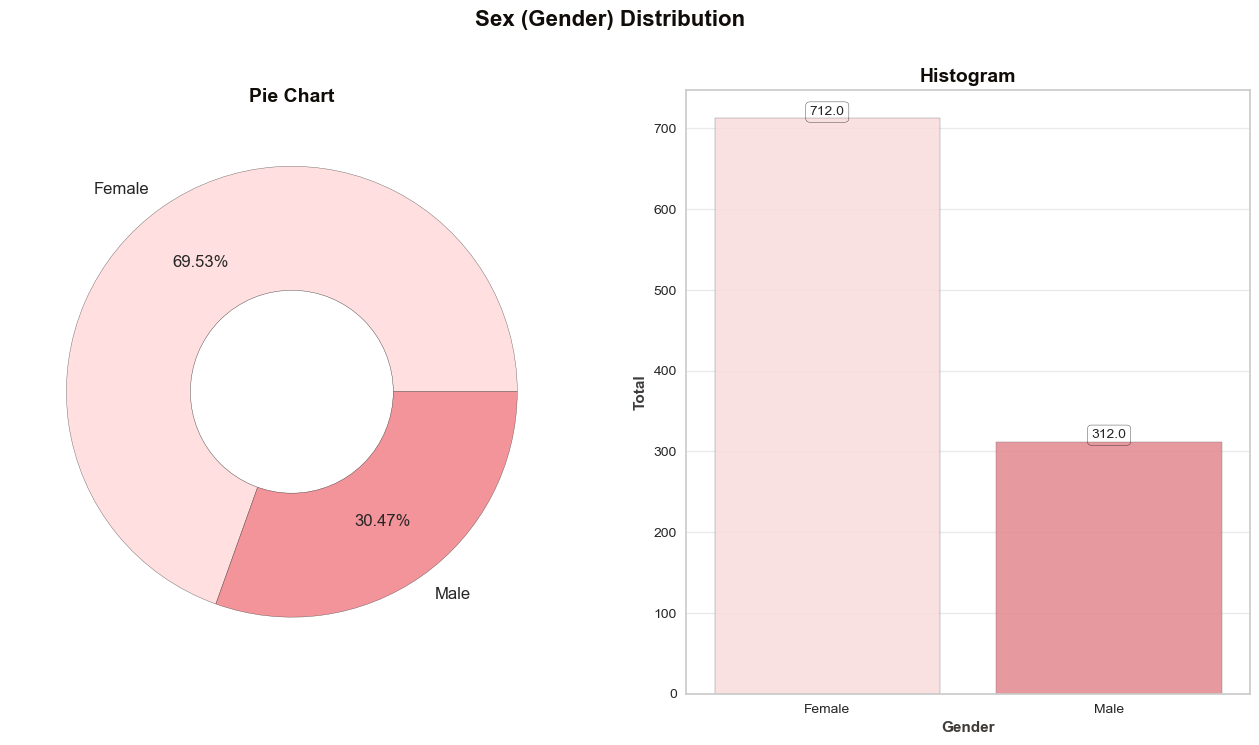

In [12]:
'''
Pay more attention to check the attributes we added noise to see the change/difference by comparing with
'''
# --- Setting Colors, Labels, Order ---
colors=color_mix[2:4]
labels=['Female', 'Male']
order=df_v2['sex'].value_counts().index

# --- Size for Both Figures ---
plt.figure(figsize=(16, 8))
plt.suptitle('Sex (Gender) Distribution', fontweight='heavy', 
             fontsize='16', fontfamily='sans-serif', color=black_grad[0])

# --- Pie Chart ---
plt.subplot(1, 2, 1)
plt.title('Pie Chart', fontweight='bold', fontsize=14,
          fontfamily='sans-serif', color=black_grad[0])
plt.pie(df_v2['sex'].value_counts(), labels=labels, colors=colors, pctdistance=0.7,
        autopct='%.2f%%', wedgeprops=dict(alpha=0.8, edgecolor=black_grad[1]),
        textprops={'fontsize':12})
centre=plt.Circle((0, 0), 0.45, fc='white', edgecolor=black_grad[1])
plt.gcf().gca().add_artist(centre)

# --- Histogram ---
countplt = plt.subplot(1, 2, 2)
plt.title('Histogram', fontweight='bold', fontsize=14, 
          fontfamily='sans-serif', color=black_grad[0])
ax = sns.countplot(x='sex', data=df_v2, palette=colors, order=order,
                   edgecolor=black_grad[2], alpha=0.85)
for rect in ax.patches:
    ax.text (rect.get_x()+rect.get_width()/2, 
             rect.get_height()+4.25,rect.get_height(), 
             horizontalalignment='center', fontsize=10, 
             bbox=dict(facecolor='none', edgecolor=black_grad[0], 
                       linewidth=0.25, boxstyle='round'))

plt.xlabel('Gender', fontweight='bold', fontsize=11, fontfamily='sans-serif', 
           color=black_grad[1])
plt.ylabel('Total', fontweight='bold', fontsize=11, fontfamily='sans-serif', 
           color=black_grad[1])
plt.xticks([0, 1], labels)
plt.grid(axis='y', alpha=0.4)
countplt
# --- Count Categorical Labels w/out Dropping Null Walues ---
print('*' * 25)
print('\033[1m'+'.: Sex (Gender) Total :.'+'\033[0m')
print('*' * 25)
df_v2.sex.value_counts(dropna=False)

******************************
.: Chest Pain Type Total :.
******************************


0    496
2    284
1    167
3     77
Name: cp, dtype: int64

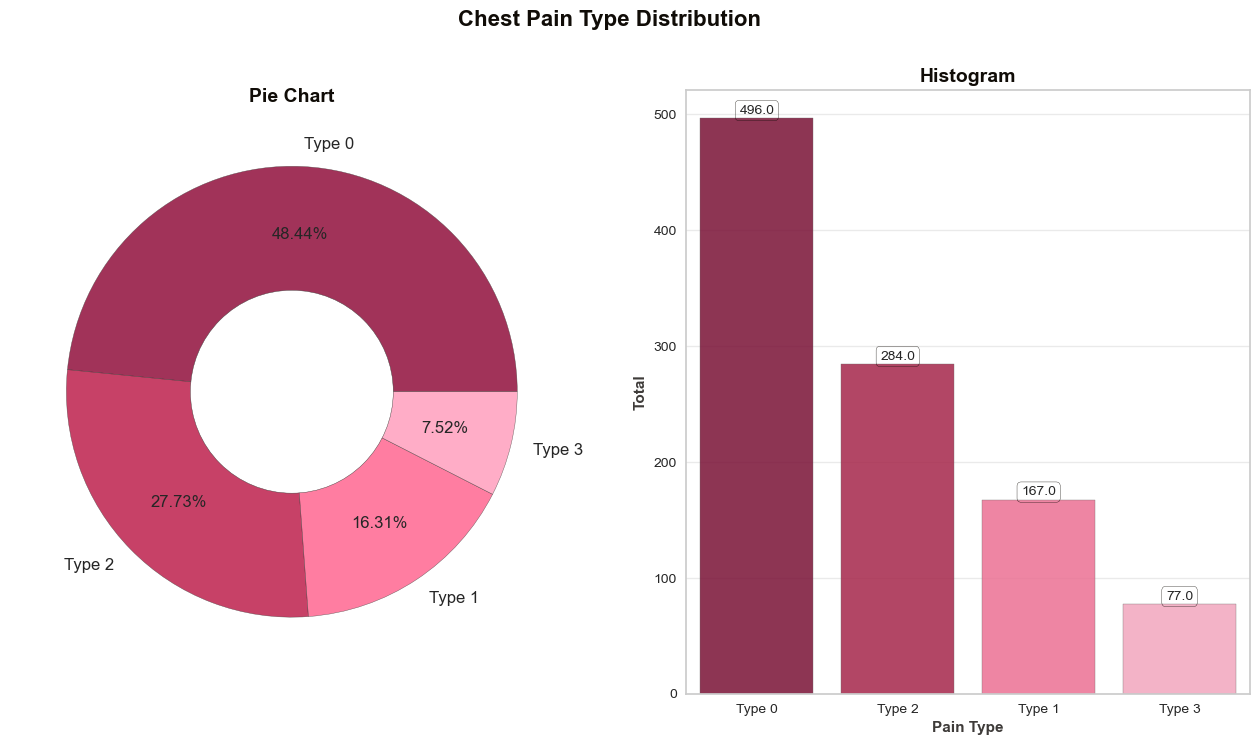

In [13]:
# --- Setting Colors, Labels, Order ---
colors=pink_grad[0:4]
labels=['Type 0', 'Type 2', 'Type 1', 'Type 3']
order=df_v2['cp'].value_counts().index

# --- Size for Both Figures ---
plt.figure(figsize=(16, 8))
plt.suptitle('Chest Pain Type Distribution', fontweight='heavy', fontsize=16, 
             fontfamily='sans-serif', color=black_grad[0])

# --- Pie Chart ---
plt.subplot(1, 2, 1)
plt.title('Pie Chart', fontweight='bold', fontsize=14,fontfamily='sans-serif', 
          color=black_grad[0])
plt.pie(df_v2['cp'].value_counts(), labels=labels, colors=colors, pctdistance=0.7, 
        autopct='%.2f%%', textprops={'fontsize':12},
        wedgeprops=dict(alpha=0.8, edgecolor=black_grad[1]))
centre=plt.Circle((0, 0), 0.45, fc='white', edgecolor=black_grad[1])
plt.gcf().gca().add_artist(centre)

# --- Histogram ---
countplt = plt.subplot(1, 2, 2)
plt.title('Histogram', fontweight='bold', fontsize=14, fontfamily='sans-serif', 
          color=black_grad[0])
ax = sns.countplot(x='cp', data=df_v2, palette=colors, order=order,
                   edgecolor=black_grad[2], alpha=0.85)
for rect in ax.patches:
    ax.text (rect.get_x()+rect.get_width()/2, 
             rect.get_height()+4.25,rect.get_height(), 
             horizontalalignment='center', fontsize=10,
             bbox=dict(facecolor='none', edgecolor=black_grad[0], linewidth=0.25,
                       boxstyle='round'))

plt.xlabel('Pain Type', fontweight='bold', fontsize=11, fontfamily='sans-serif', 
           color=black_grad[1])
plt.ylabel('Total', fontweight='bold', fontsize=11, fontfamily='sans-serif', 
           color=black_grad[1])
plt.xticks([0, 1, 2, 3], labels)
plt.grid(axis='y', alpha=0.4)
countplt

# --- Count Categorical Labels w/out Dropping Null Walues ---
print('*' * 30)
print('\033[1m'+'.: Chest Pain Type Total :.'+'\033[0m')
print('*' * 30)
df_v2.cp.value_counts(dropna=False)

********************************
.: Fasting Blood Sugar Total :.
********************************


0    871
1    153
Name: fbs, dtype: int64

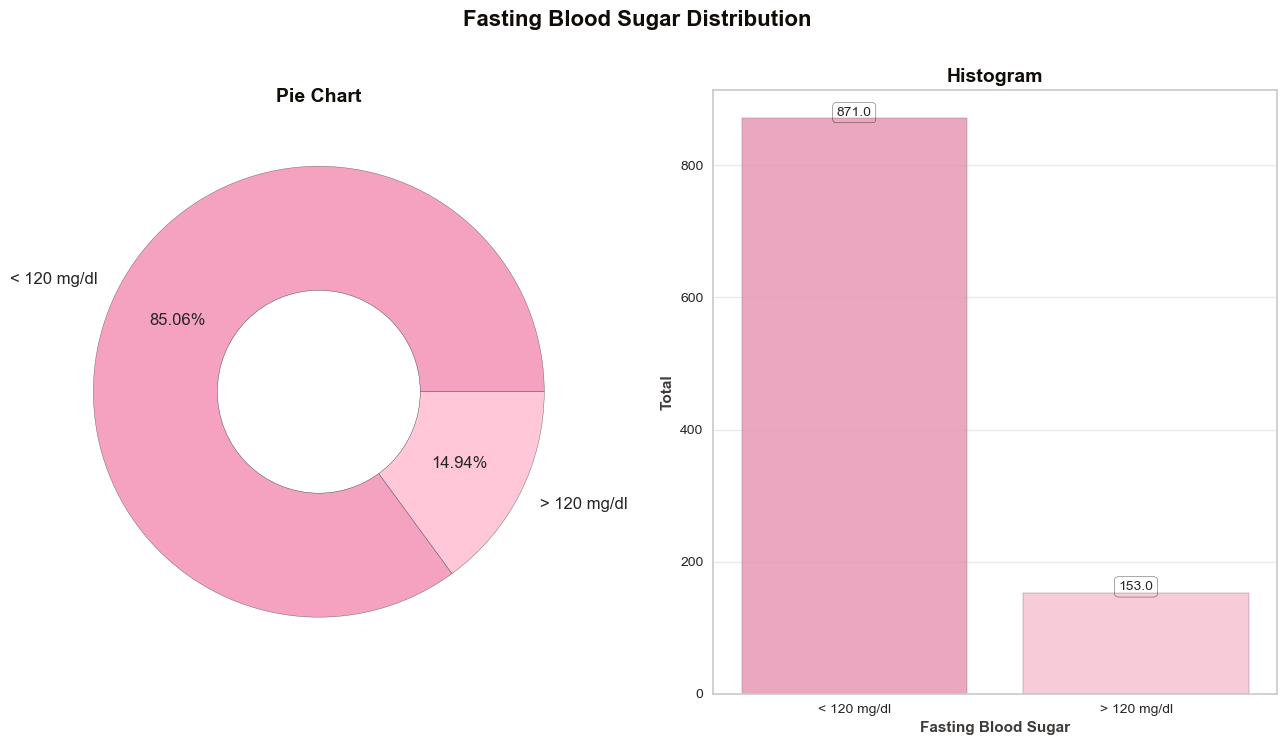

In [14]:
# --- Setting Colors, Labels, Order ---
colors=color_mix[0:2]
labels=['< 120 mg/dl', '> 120 mg/dl']
order=df_v2['fbs'].value_counts().index

# --- Size for Both Figures ---
plt.figure(figsize=(16, 8))
plt.suptitle('Fasting Blood Sugar Distribution', fontweight='heavy', 
             fontsize=16, fontfamily='sans-serif', color=black_grad[0])

# --- Pie Chart ---
plt.subplot(1, 2, 1)
plt.title('Pie Chart', fontweight='bold', fontsize=14, fontfamily='sans-serif', 
          color=black_grad[0])
plt.pie(df_v2['fbs'].value_counts(), labels=labels, colors=colors,
        wedgeprops=dict(alpha=0.8, edgecolor=black_grad[1]), autopct='%.2f%%',
        pctdistance=0.7, textprops={'fontsize':12})
centre=plt.Circle((0, 0), 0.45, fc='white', edgecolor=black_grad[1])
plt.gcf().gca().add_artist(centre)

# --- Histogram ---
countplt = plt.subplot(1, 2, 2)
plt.title('Histogram', fontweight='bold', fontsize=14, fontfamily='sans-serif', 
          color=black_grad[0])
ax = sns.countplot(x='fbs', data=df_v2, palette=colors, order=order,
                   edgecolor=black_grad[2], alpha=0.85)
for rect in ax.patches:
    ax.text (rect.get_x()+rect.get_width()/2, 
             rect.get_height()+4.25,rect.get_height(), 
             horizontalalignment='center', fontsize=10,
             bbox=dict(facecolor='none', edgecolor=black_grad[0], linewidth=0.25,
                       boxstyle='round'))

plt.xlabel('Fasting Blood Sugar', fontweight='bold', fontsize=11, 
           fontfamily='sans-serif', color=black_grad[1])
plt.ylabel('Total', fontweight='bold', fontsize=11, fontfamily='sans-serif', 
           color=black_grad[1])
plt.xticks([0, 1], labels)
plt.grid(axis='y', alpha=0.4)
countplt


# --- Count Categorical Labels w/out Dropping Null Walues ---
print('*' * 32)
print('\033[1m'+'.: Fasting Blood Sugar Total :.'+'\033[0m')
print('*' * 32)
df_v2.fbs.value_counts(dropna=False)

**************************************************
.: Resting Electrocardiographic Results Total :.
**************************************************


1    513
0    496
2     15
Name: restecg, dtype: int64

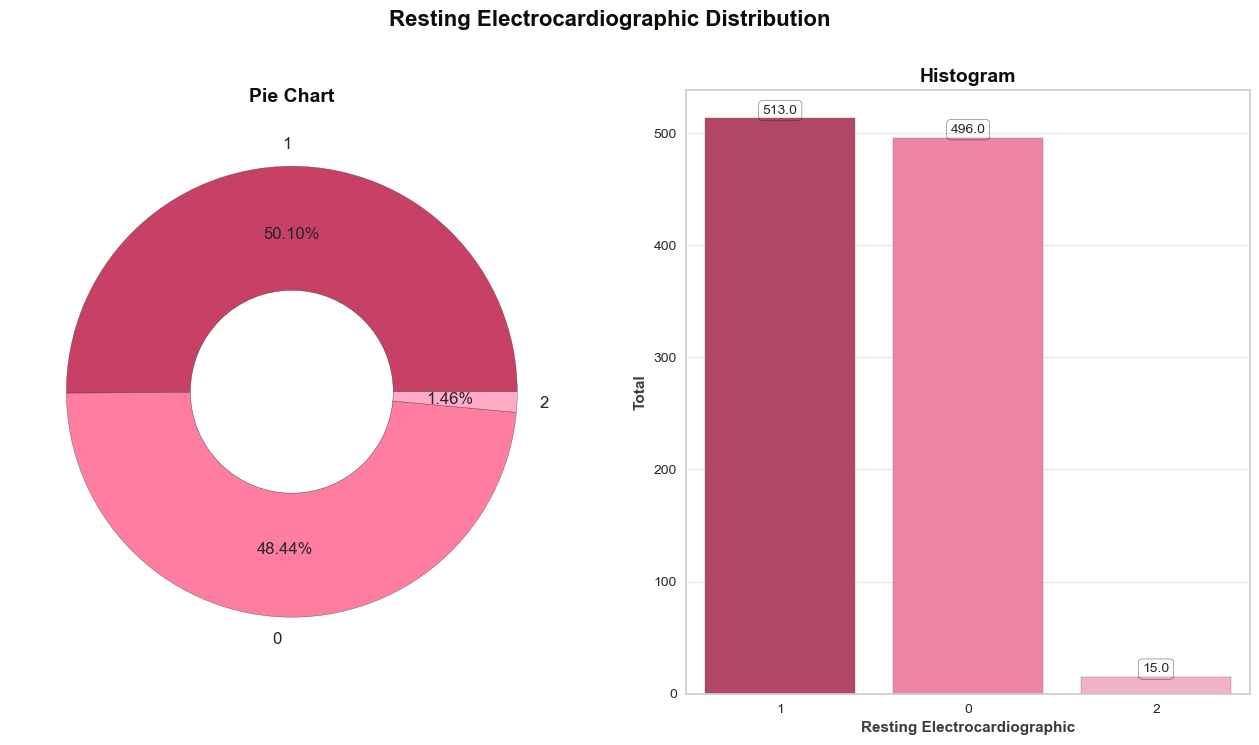

In [15]:
# --- Setting Colors, Labels, Order ---
colors=pink_grad[1:4]
labels=['1', '0', '2']
order=df_v2['restecg'].value_counts().index

# --- Size for Both Figures ---
plt.figure(figsize=(16, 8))
plt.suptitle('Resting Electrocardiographic Distribution', fontweight='heavy', 
             fontsize=16, fontfamily='sans-serif', color=black_grad[0])

# --- Pie Chart ---
plt.subplot(1,2,1)
plt.title('Pie Chart', fontweight='bold', fontsize=14, fontfamily='sans-serif', 
          color=black_grad[0])
plt.pie(df_v2['restecg'].value_counts(), labels=labels, colors=colors, 
        wedgeprops=dict(alpha=0.8, edgecolor=black_grad[1]), autopct='%.2f%%',
        pctdistance=0.7, textprops={'fontsize':12})
centre=plt.Circle((0, 0), 0.45, fc='white', edgecolor=black_grad[1])
plt.gcf().gca().add_artist(centre)

# --- Histogram ---
countplt = plt.subplot(1, 2, 2)
plt.title('Histogram', fontweight='bold', fontsize=14, fontfamily='sans-serif', 
          color=black_grad[0])
ax = sns.countplot(x='restecg', data=df_v2, palette=colors, order=order,
                   edgecolor=black_grad[2], alpha=0.85)
for rect in ax.patches:
    ax.text (rect.get_x()+rect.get_width()/2, 
             rect.get_height()+4.25,rect.get_height(), 
             horizontalalignment='center', fontsize=10,
             bbox=dict(facecolor='none', edgecolor=black_grad[0], linewidth=0.25,
                       boxstyle='round'))

plt.xlabel('Resting Electrocardiographic', fontweight='bold', fontsize=11, 
           fontfamily='sans-serif', color=black_grad[1])
plt.ylabel('Total', fontweight='bold', fontsize=11, fontfamily='sans-serif', 
           color=black_grad[1])
plt.grid(axis='y', alpha=0.4)
countplt

# --- Count Categorical Labels w/out Dropping Null Walues ---
print('*' * 50)
print('\033[1m'+'.: Resting Electrocardiographic Results Total :.'+'\033[0m')
print('*' * 50)
df_v2.restecg.value_counts(dropna=False)

***********************************
.: Exercise Induced Angina Total :.
***********************************


0    680
1    344
Name: exang, dtype: int64

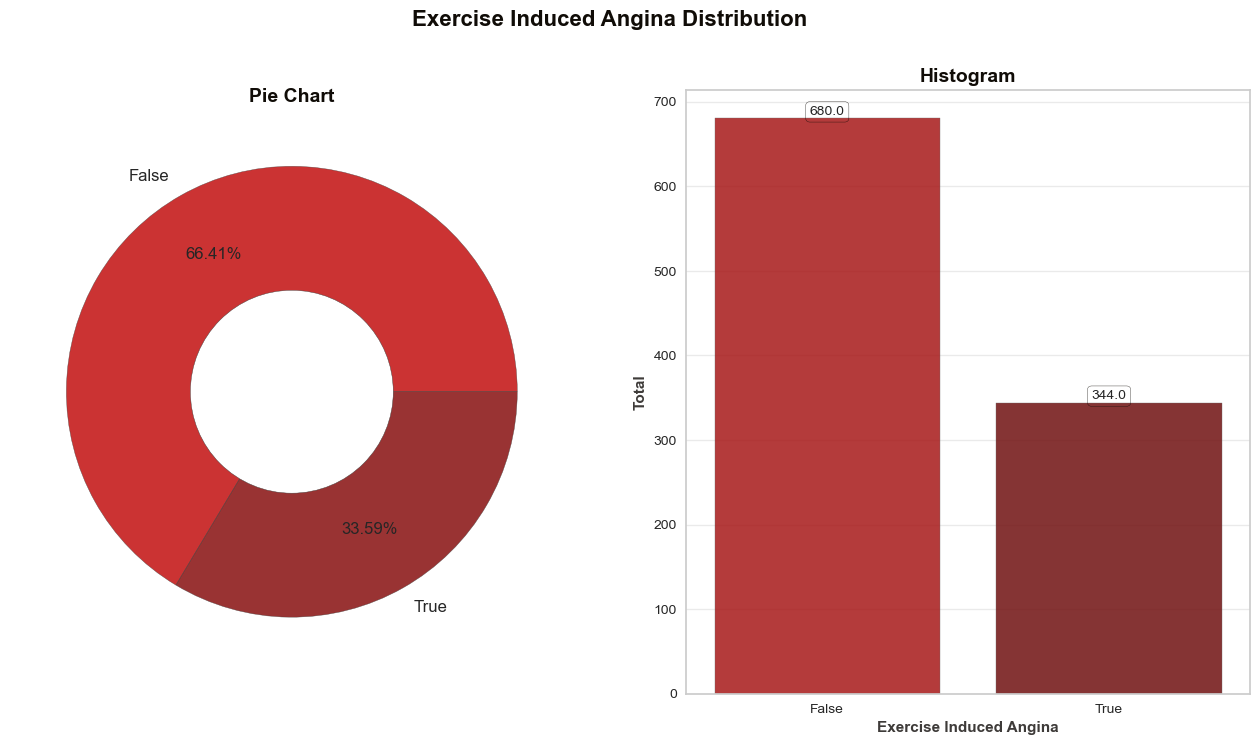

In [16]:
# --- Setting Colors, Labels, Order ---
colors=red_grad[1:3]
labels=['False', 'True']
order=df_v2['exang'].value_counts().index

# --- Size for Both Figures ---
plt.figure(figsize=(16, 8))
plt.suptitle('Exercise Induced Angina Distribution', fontweight='heavy', 
             fontsize=16, fontfamily='sans-serif', color=black_grad[0])

# --- Pie Chart ---
plt.subplot(1,2,1)
plt.title('Pie Chart', fontweight='bold', fontsize=14, fontfamily='sans-serif',
          color=black_grad[0])
plt.pie(df_v2['exang'].value_counts(), labels=labels, colors=colors, 
        wedgeprops=dict(alpha=0.8, edgecolor=black_grad[1]), autopct='%.2f%%',
        pctdistance=0.7, textprops={'fontsize':12})
centre=plt.Circle((0, 0), 0.45, fc='white', edgecolor=black_grad[1])
plt.gcf().gca().add_artist(centre)

# --- Histogram ---
countplt = plt.subplot(1, 2, 2)
plt.title('Histogram', fontweight='bold', fontsize=14, fontfamily='sans-serif', 
          color=black_grad[0])
ax = sns.countplot(x='exang', data=df_v2, palette=colors, order=order,
                   edgecolor=black_grad[2], alpha=0.85)
for rect in ax.patches:
    ax.text (rect.get_x()+rect.get_width()/2, 
             rect.get_height()+4.25,rect.get_height(), 
             horizontalalignment='center', fontsize=10,
             bbox=dict(facecolor='none', edgecolor=black_grad[0], linewidth=0.25,
                       boxstyle='round'))

plt.xlabel('Exercise Induced Angina', fontweight='bold', fontsize=11, 
           fontfamily='sans-serif', color=black_grad[1])
plt.ylabel('Total', fontweight='bold', fontsize=11, fontfamily='sans-serif', 
           color=black_grad[1])
plt.xticks([0, 1], labels)
plt.grid(axis='y', alpha=0.4)
countplt

# --- Count Categorical Labels w/out Dropping Null Walues ---
print('*' * 35)
print('\033[1m'+'.: Exercise Induced Angina Total :.'+'\033[0m')
print('*' * 35)
df_v2.exang.value_counts(dropna=False)

********************
.: Slope Total :.
********************


1    482
2    468
0     74
Name: slope, dtype: int64

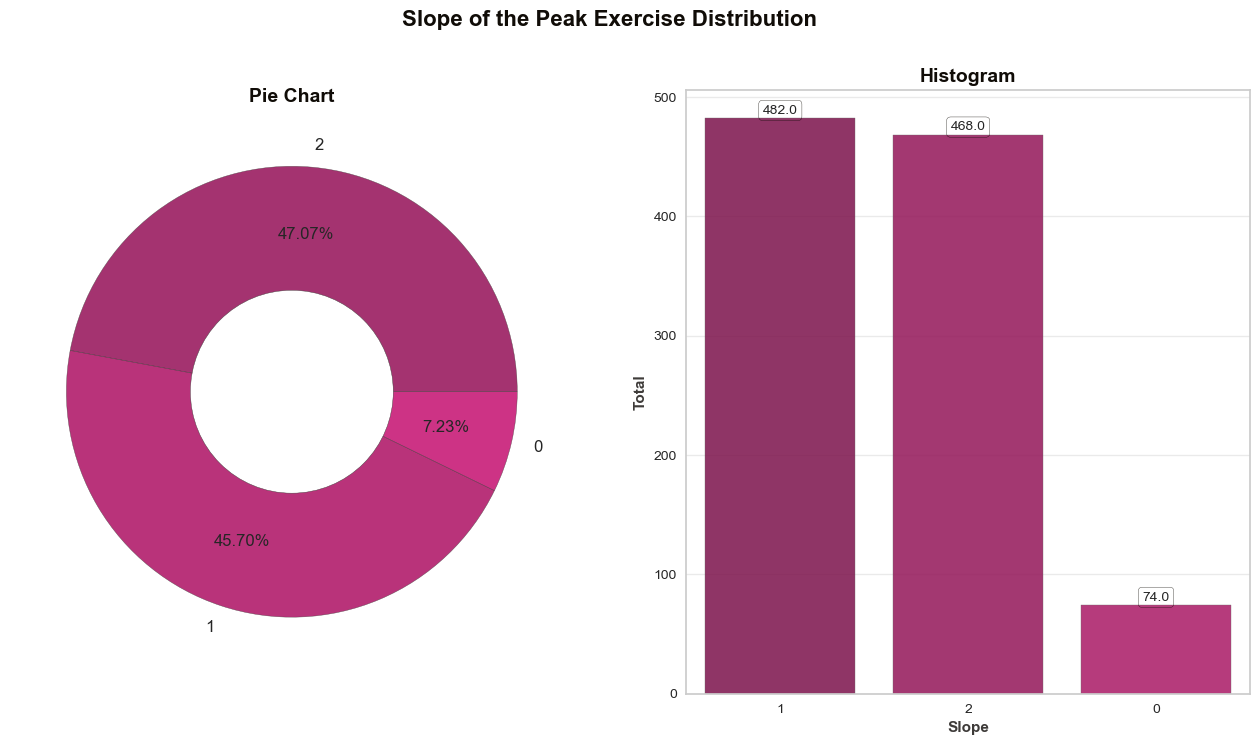

In [17]:
# --- Setting Colors, Labels, Order ---
colors=purple_grad[2:5]
labels=['2', '1', '0']
order=df_v2['slope'].value_counts().index

# --- Size for Both Figures ---
plt.figure(figsize=(16, 8))
plt.suptitle('Slope of the Peak Exercise Distribution', fontweight='heavy', 
             fontsize=16, fontfamily='sans-serif', color=black_grad[0])

# --- Pie Chart ---
plt.subplot(1, 2, 1)
plt.title('Pie Chart', fontweight='bold', fontsize=14,
          fontfamily='sans-serif', color=black_grad[0])
plt.pie(df_v2['slope'].value_counts(), labels=labels, colors=colors, 
        wedgeprops=dict(alpha=0.8, edgecolor=black_grad[1]), autopct='%.2f%%',
        pctdistance=0.7, textprops={'fontsize':12})
centre=plt.Circle((0, 0), 0.45, fc='white', edgecolor=black_grad[1])
plt.gcf().gca().add_artist(centre)


# --- Histogram ---
countplt = plt.subplot(1, 2, 2)
plt.title('Histogram', fontweight='bold', fontsize=14, fontfamily='sans-serif', 
          color=black_grad[0])
ax = sns.countplot(x='slope', data=df_v2, palette=colors, order=order,
                   edgecolor=black_grad[2], alpha=0.85)
for rect in ax.patches:
    ax.text (rect.get_x()+rect.get_width()/2, 
             rect.get_height()+4.25,rect.get_height(), 
             horizontalalignment='center', fontsize=10,
             bbox=dict(facecolor='none', edgecolor=black_grad[0], linewidth=0.25,
                       boxstyle='round'))

plt.xlabel('Slope', fontweight='bold', fontsize=11, fontfamily='sans-serif', 
           color=black_grad[1])
plt.ylabel('Total', fontweight='bold', fontsize=11, fontfamily='sans-serif', 
           color=black_grad[1])
plt.grid(axis='y', alpha=0.4)
countplt
# --- Count Categorical Labels w/out Dropping Null Walues ---
print('*' * 20)
print('\033[1m'+'.: Slope Total :.'+'\033[0m')
print('*' * 20)
df_v2.slope.value_counts(dropna=False)

****************************************
.: Number of Major Vessels Total :.
****************************************


0    578
1    226
2    134
3     68
4     18
Name: ca, dtype: int64

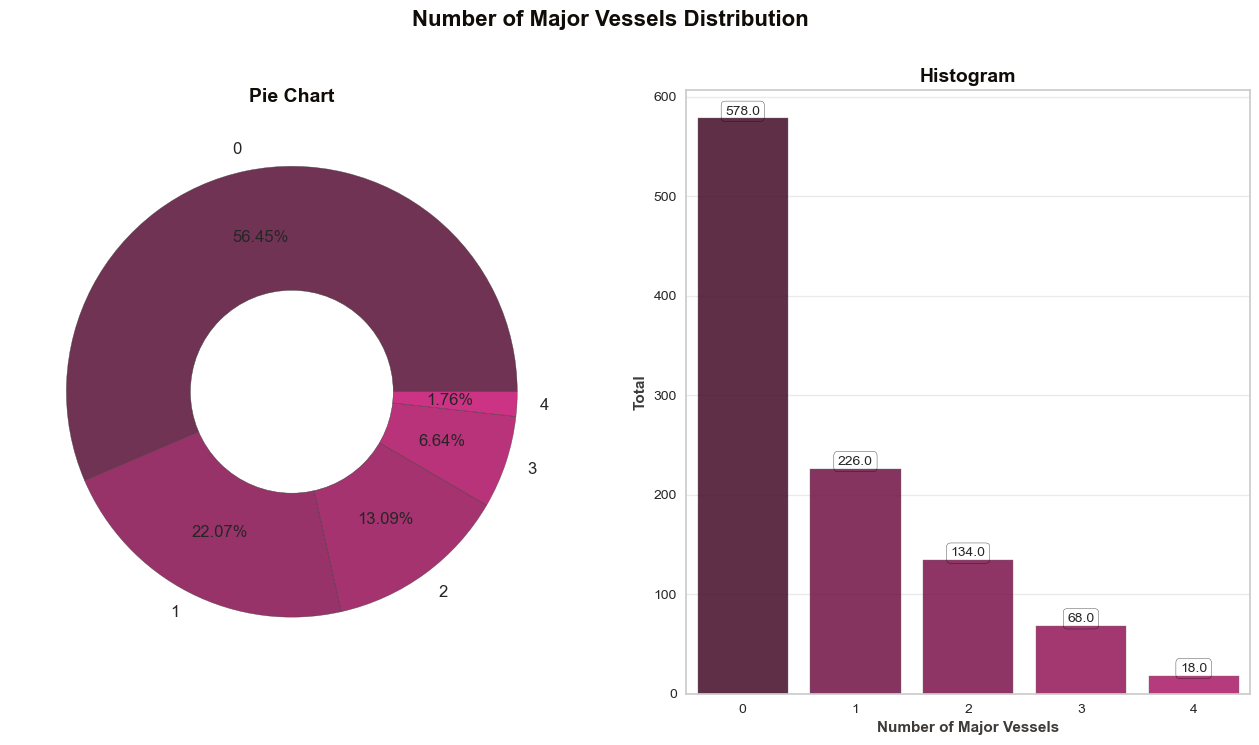

In [18]:
# --- Setting Colors, Labels, Order ---
colors=purple_grad
labels=['0', '1', '2', '3', '4']
order=df_v2['ca'].value_counts().index

# --- Size for Both Figures ---
plt.figure(figsize=(16, 8))
plt.suptitle('Number of Major Vessels Distribution', fontweight='heavy', 
             fontsize=16, fontfamily='sans-serif', color=black_grad[0])

# --- Pie Chart ---
plt.subplot(1,2,1)
plt.title('Pie Chart', fontweight='bold', fontsize=14, fontfamily='sans-serif',
          color=black_grad[0])
plt.pie(df_v2['ca'].value_counts(), labels=labels, colors=colors, 
        wedgeprops=dict(alpha=0.8, edgecolor=black_grad[1]), 
        autopct='%.2f%%', pctdistance=0.7, textprops={'fontsize':12})

centre=plt.Circle((0, 0), 0.45, fc='white', edgecolor=black_grad[1])
plt.gcf().gca().add_artist(centre)

# --- Histogram ---
countplt = plt.subplot(1, 2, 2)
plt.title('Histogram', fontweight='bold', fontsize=14, fontfamily='sans-serif', 
          color=black_grad[0])
ax = sns.countplot(x='ca', data=df_v2, palette=colors, order=order,
                   edgecolor=black_grad[2], alpha=0.85)
for rect in ax.patches:
    ax.text (rect.get_x()+rect.get_width()/2, 
             rect.get_height()+4.25,rect.get_height(), 
             horizontalalignment='center', fontsize=10,
             bbox=dict(facecolor='none', edgecolor=black_grad[0], linewidth=0.25,
                       boxstyle='round'))

plt.xlabel('Number of Major Vessels', fontweight='bold', fontsize=11, 
           fontfamily='sans-serif', color=black_grad[1])
plt.ylabel('Total', fontweight='bold', fontsize=11, fontfamily='sans-serif', 
           color=black_grad[1])
plt.grid(axis='y', alpha=0.4)
countplt

# --- Count Categorical Labels w/out Dropping Null Walues ---
print('*' * 40)
print('\033[1m'+'.: Number of Major Vessels Total :.'+'\033[0m')
print('*' * 40)
df_v2.ca.value_counts(dropna=False)

********************
.: "thal" Total :.
********************


2    543
3    410
1     64
0      7
Name: thal, dtype: int64

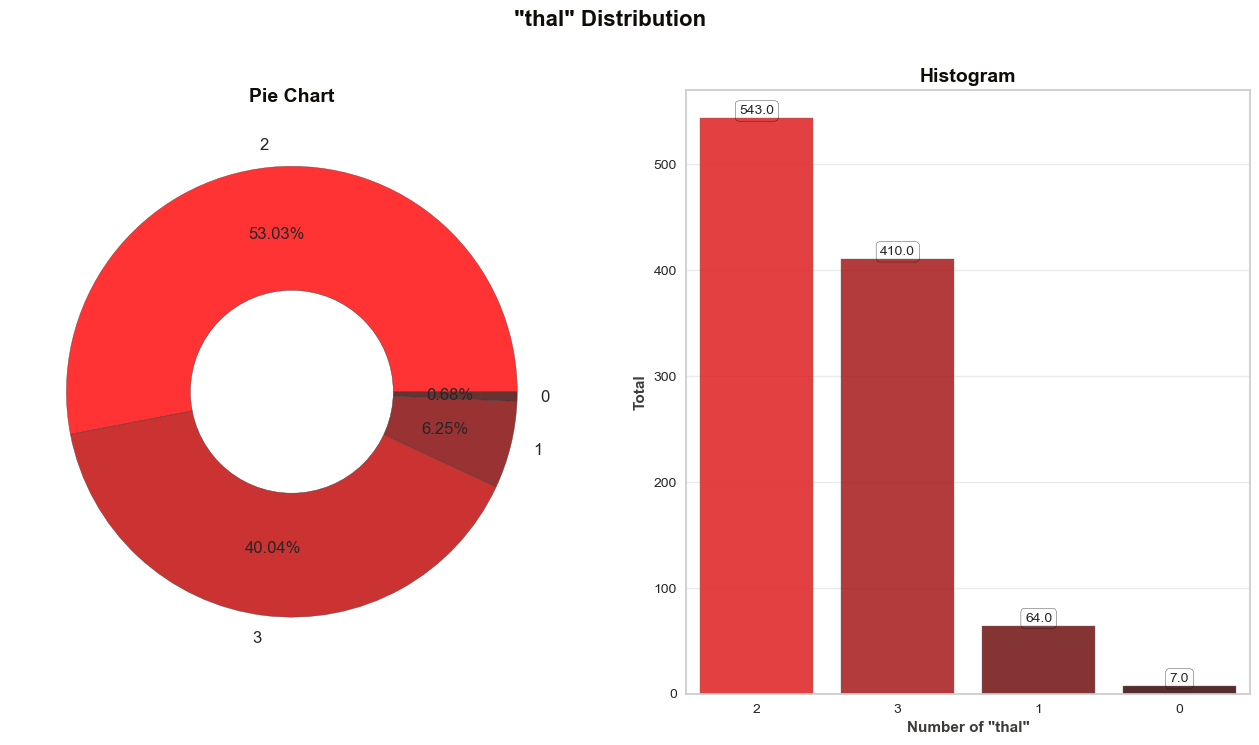

In [19]:
# --- Setting Colors, Labels, Order ---
colors=red_grad[0:4]
labels=['2', '3', '1', '0']
order=df_v2['thal'].value_counts().index

# --- Size for Both Figures ---
plt.figure(figsize=(16,8))
plt.suptitle('"thal" Distribution', fontweight='heavy', fontsize=16, 
             fontfamily='sans-serif', color=black_grad[0])

# --- Pie Chart ---
plt.subplot(1,2,1)
plt.title('Pie Chart', fontweight='bold', fontsize=14, fontfamily='sans-serif', 
          color=black_grad[0])
plt.pie(df_v2['thal'].value_counts(), labels=labels, colors=colors, 
        wedgeprops=dict(alpha=0.8, edgecolor=black_grad[1]), 
        autopct='%.2f%%', pctdistance=0.7, textprops={'fontsize':12})

centre=plt.Circle((0, 0), 0.45, fc='white', edgecolor=black_grad[1])
plt.gcf().gca().add_artist(centre)

# --- Histogram ---
countplt = plt.subplot(1, 2, 2)
plt.title('Histogram', fontweight='bold', fontsize=14, fontfamily='sans-serif', 
          color=black_grad[0])
ax = sns.countplot(x='thal', data=df_v2, palette=colors, order=order,
                   edgecolor=black_grad[2], alpha=0.85)
for rect in ax.patches:
    ax.text (rect.get_x()+rect.get_width()/2, 
             rect.get_height()+4.25,rect.get_height(), 
             horizontalalignment='center', fontsize=10,
             bbox=dict(facecolor='none', edgecolor=black_grad[0], linewidth=0.25,
                       boxstyle='round'))

plt.xlabel('Number of "thal"', fontweight='bold', fontsize=11, 
           fontfamily='sans-serif', color=black_grad[1])
plt.ylabel('Total', fontweight='bold', fontsize=11, fontfamily='sans-serif', 
           color=black_grad[1])
plt.grid(axis='y', alpha=0.4)
countplt

# --- Count Categorical Labels w/out Dropping Null Walues ---
print('*' * 20)
print('\033[1m'+'.: "thal" Total :.'+'\033[0m')
print('*' * 20)
df_v2.thal.value_counts(dropna=False)

*********************************************
.: Heart Diseases Status (target) Total :.
*********************************************


1    526
0    498
Name: target, dtype: int64

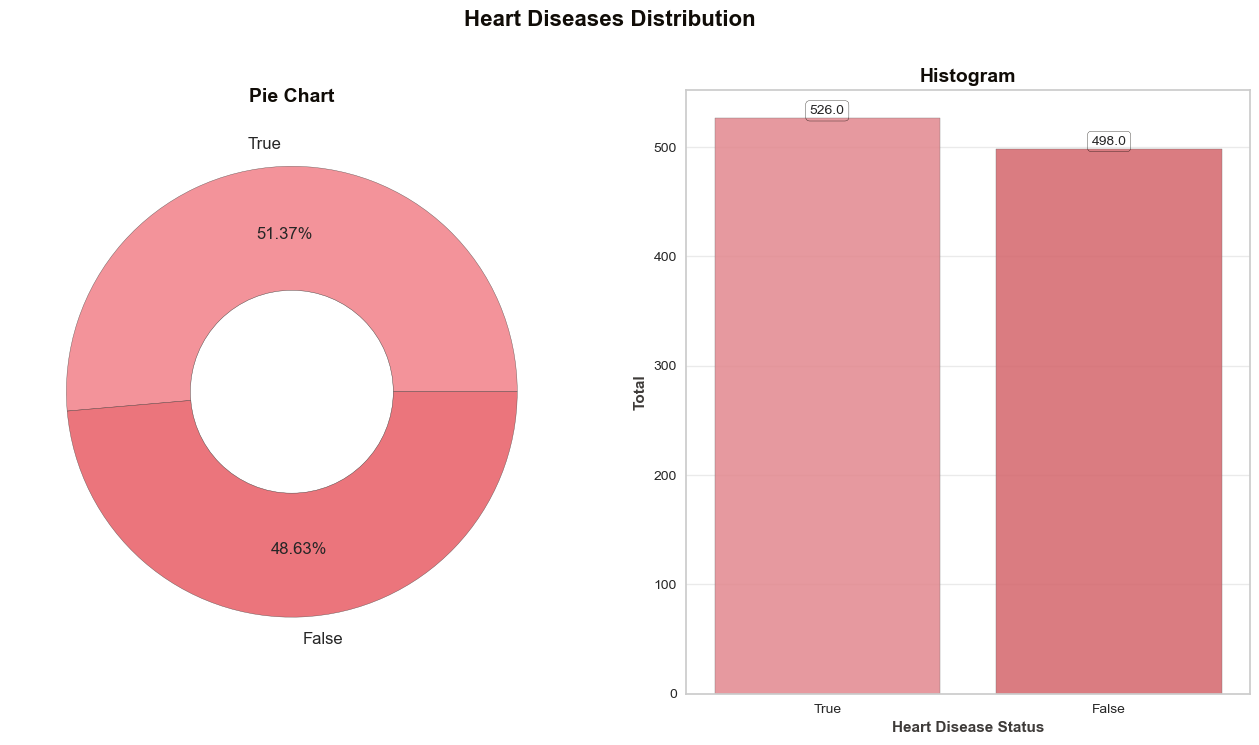

In [20]:
# --- Setting Colors, Labels, Order ---
colors=color_mix[3:5]
labels=['True', 'False']
order=df_v2['target'].value_counts().index

# --- Size for Both Figures ---
plt.figure(figsize=(16,8))
plt.suptitle('Heart Diseases Distribution', fontweight='heavy', 
             fontsize=16, fontfamily='sans-serif', color=black_grad[0])

# --- Pie Chart ---
plt.subplot(1, 2, 1)
plt.title('Pie Chart', fontweight='bold', fontsize=14, fontfamily='sans-serif',
          color=black_grad[0])
plt.pie(df_v2['target'].value_counts(), labels=labels, colors=colors, 
        wedgeprops=dict(alpha=0.8, edgecolor=black_grad[1]), autopct='%.2f%%',
        pctdistance=0.7, textprops={'fontsize':12})
centre=plt.Circle((0, 0), 0.45, fc='white', edgecolor=black_grad[1])
plt.gcf().gca().add_artist(centre)

# --- Histogram ---
countplt = plt.subplot(1, 2, 2)
plt.title('Histogram', fontweight='bold', fontsize=14, fontfamily='sans-serif', 
          color=black_grad[0])
ax = sns.countplot(x='target', data=df_v2, palette=colors, order=order,
                   edgecolor=black_grad[2], alpha=0.85)
for rect in ax.patches:
    ax.text (rect.get_x()+rect.get_width()/2, 
             rect.get_height()+4.25,rect.get_height(), 
             horizontalalignment='center', fontsize=10,
             bbox=dict(facecolor='none', edgecolor=black_grad[0], linewidth=0.25,
                       boxstyle='round'))

plt.xlabel('Heart Disease Status', fontweight='bold', fontsize=11, 
           fontfamily='sans-serif', color=black_grad[1])
plt.ylabel('Total', fontweight='bold', fontsize=11, fontfamily='sans-serif', 
           color=black_grad[1])
plt.xticks([0, 1], labels)
plt.grid(axis='y', alpha=0.4)
countplt

# --- Count Categorical Labels w/out Dropping Null Walues ---
print('*' * 45)
print('\033[1m'+'.: Heart Diseases Status (target) Total :.'+'\033[0m')
print('*' * 45)
df_v2.target.value_counts(dropna=False)

In [21]:
'''
Numerical Variable
Descriptive Statistics

'''
# --- Descriptive Statistics ---
df.select_dtypes(exclude='object').describe().T.style.background_gradient(cmap='PuRd').set_properties(**{'font-family': 'Segoe UI'})

,count,mean,std,min,25%,50%,75%,max
age,1025.000000,54.434146,9.072290,29.000000,48.000000,56.000000,61.000000,77.000000
sex,1025.000000,0.695610,0.460373,0.000000,0.000000,1.000000,1.000000,1.000000
cp,1025.000000,0.942439,1.029641,0.000000,0.000000,1.000000,2.000000,3.000000
trestbps,1025.000000,131.611707,17.516718,94.000000,120.000000,130.000000,140.000000,200.000000
chol,1025.000000,246.000000,51.592510,126.000000,211.000000,240.000000,275.000000,564.000000
fbs,1025.000000,0.149268,0.356527,0.000000,0.000000,0.000000,0.000000,1.000000
restecg,1025.000000,0.529756,0.527878,0.000000,0.000000,1.000000,1.000000,2.000000
thalach,1025.000000,149.114146,23.005724,71.000000,132.000000,152.000000,166.000000,202.000000
exang,1025.000000,0.336585,0.472772,0.000000,0.000000,0.000000,1.000000,1.000000
oldpeak,1025.000000,1.071512,1.175053,0.000000,0.000000,0.800000,1.800000,6.200000


.: Age Column Skewness & Kurtosis :.
****************************************
Skewness: -0.249
Kurtosis: -0.526




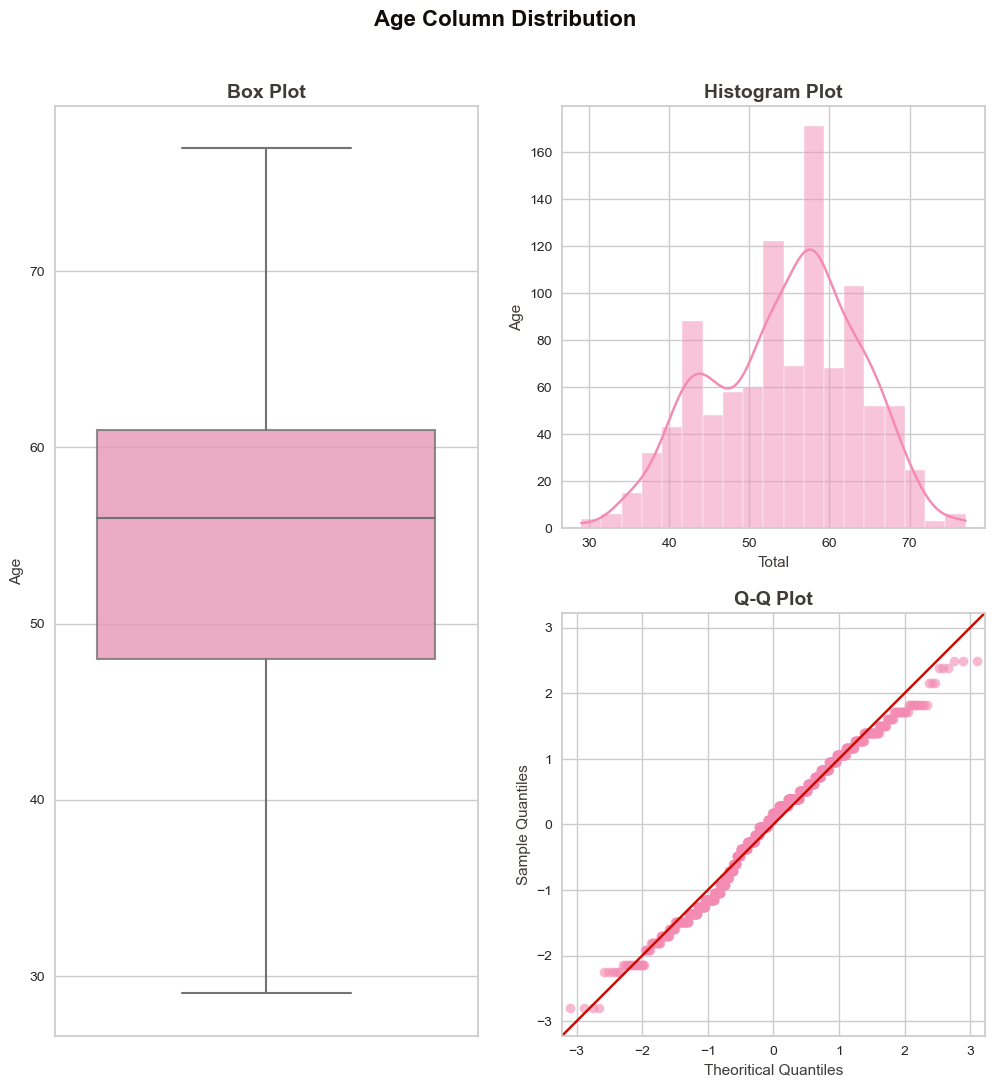

In [22]:
'''
Continuous Column Distribution
'''
# --- Variable, Color & Plot Size ---
var = 'age'
color = color_mix[0]
fig=plt.figure(figsize=(12, 12))

# --- Skewness & Kurtosis ---
print('\033[1m'+'.: Age Column Skewness & Kurtosis :.'+'\033[0m')
print('*' * 40)
print('Skewness:'+'\033[1m {:.3f}'.format(df[var].skew(axis = 0, skipna = True)))
print('\033[0m'+'Kurtosis:'+'\033[1m {:.3f}'.format(df[var].kurt(axis = 0, skipna = True)))
print('\n')

# --- General Title ---
fig.suptitle('Age Column Distribution', fontweight='bold', fontsize=16, 
             fontfamily='sans-serif', color=black_grad[0])
fig.subplots_adjust(top=0.9)

# --- Histogram ---
ax_1=fig.add_subplot(2, 2, 2)
plt.title('Histogram Plot', fontweight='bold', fontsize=14, 
          fontfamily='sans-serif', color=black_grad[1])
sns.histplot(data=df, x=var, kde=True, color=color)
plt.xlabel('Total', fontweight='regular', fontsize=11, 
           fontfamily='sans-serif', color=black_grad[1])
plt.ylabel('Age', fontweight='regular', fontsize=11, fontfamily='sans-serif', 
           color=black_grad[1])

# --- Q-Q Plot ---
ax_2=fig.add_subplot(2, 2, 4)
plt.title('Q-Q Plot', fontweight='bold', fontsize=14, 
          fontfamily='sans-serif', color=black_grad[1])
qqplot(df[var], fit=True, line='45', ax=ax_2, markerfacecolor=color, 
       markeredgecolor=color, alpha=0.6)
plt.xlabel('Theoritical Quantiles', fontweight='regular', fontsize=11, 
           fontfamily='sans-serif', color=black_grad[1])
plt.ylabel('Sample Quantiles', fontweight='regular', fontsize=11, 
           fontfamily='sans-serif', color=black_grad[1])

# --- Box Plot ---
ax_3=fig.add_subplot(1, 2, 1)
plt.title('Box Plot', fontweight='bold', fontsize=14, fontfamily='sans-serif', 
          color=black_grad[1])
sns.boxplot(data=df, y=var, color=color, boxprops=dict(alpha=0.8), linewidth=1.5)
plt.ylabel('Age', fontweight='regular', fontsize=11, fontfamily='sans-serif', 
           color=black_grad[1])

plt.show()

.: Resting Blood Pressure Column Skewness & Kurtosis :.
*******************************************************
Skewness: 0.740
Kurtosis: 0.991




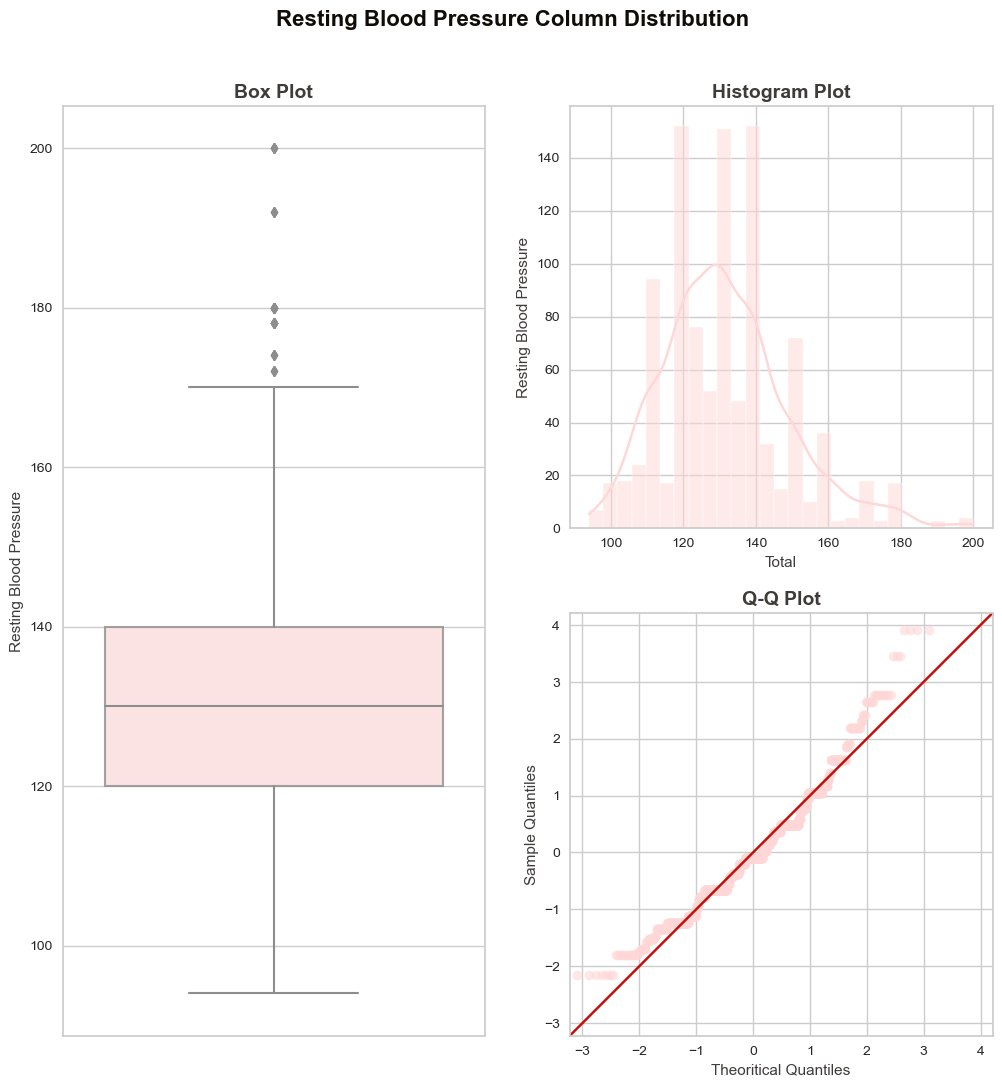

In [23]:
# --- Variable, Color & Plot Size ---
var = 'trestbps'
color = color_mix[2]
fig=plt.figure(figsize=(12, 12))

# --- Skewness & Kurtosis ---
print('\033[1m'+'.: Resting Blood Pressure Column Skewness & Kurtosis :.'+'\033[0m')
print('*' * 55)
print('Skewness:'+'\033[1m {:.3f}'.format(df[var].skew(axis = 0, skipna = True)))
print('\033[0m'+'Kurtosis:'+'\033[1m {:.3f}'.format(df[var].kurt(axis = 0, skipna = True)))
print('\n')

# --- General Title ---
fig.suptitle('Resting Blood Pressure Column Distribution', fontweight='bold', 
             fontsize=16, fontfamily='sans-serif', color=black_grad[0])
fig.subplots_adjust(top=0.9)

# --- Histogram ---
ax_1=fig.add_subplot(2, 2, 2)
plt.title('Histogram Plot', fontweight='bold', fontsize=14, 
          fontfamily='sans-serif', color=black_grad[1])
sns.histplot(data=df, x=var, kde=True, color=color)
plt.xlabel('Total', fontweight='regular', fontsize=11, 
           fontfamily='sans-serif', color=black_grad[1])
plt.ylabel('Resting Blood Pressure', fontweight='regular', fontsize=11, 
           fontfamily='sans-serif', color=black_grad[1])

# --- Q-Q Plot ---
ax_2=fig.add_subplot(2, 2, 4)
plt.title('Q-Q Plot', fontweight='bold', fontsize=14, 
          fontfamily='sans-serif', color=black_grad[1])
qqplot(df[var], fit=True, line='45', ax=ax_2, markerfacecolor=color, 
       markeredgecolor=color, alpha=0.6)
plt.xlabel('Theoritical Quantiles', fontweight='regular', fontsize=11, 
           fontfamily='sans-serif', color=black_grad[1])
plt.ylabel('Sample Quantiles', fontweight='regular', fontsize=11, 
           fontfamily='sans-serif', color=black_grad[1])

# --- Box Plot ---
ax_3=fig.add_subplot(1, 2, 1)
plt.title('Box Plot', fontweight='bold', fontsize=14, fontfamily='sans-serif', 
          color=black_grad[1])
sns.boxplot(data=df, y=var, color=color, boxprops=dict(alpha=0.8), linewidth=1.5)
plt.ylabel('Resting Blood Pressure', fontweight='regular', fontsize=11, 
           fontfamily='sans-serif', color=black_grad[1])

plt.show()

.: Maximum Heart Rate Column Skewness & Kurtosis :.
**************************************************
Skewness: -0.514
Kurtosis: -0.089




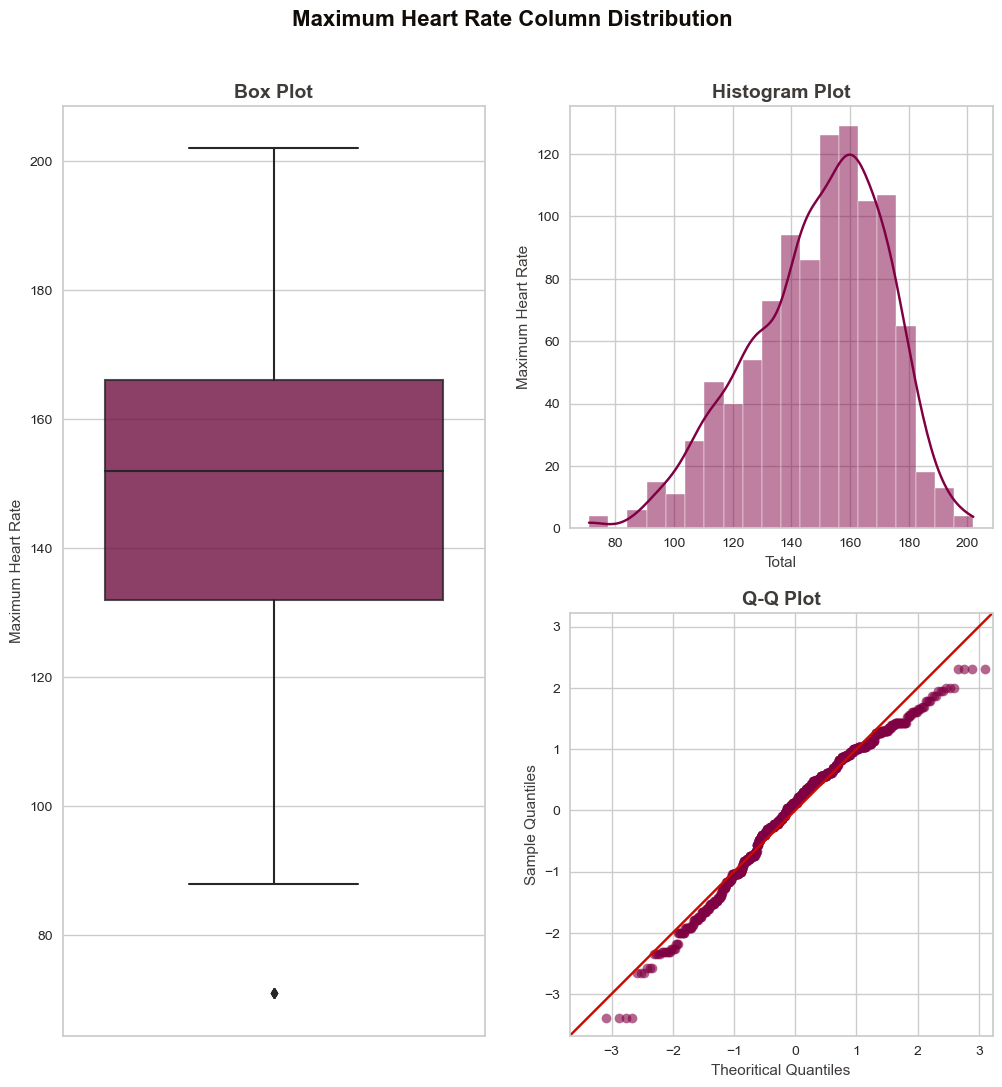

In [24]:
# --- Variable, Color & Plot Size ---
var = 'thalach'
color = purple_grad[1]
fig=plt.figure(figsize=(12, 12))

# --- Skewness & Kurtosis ---
print('\033[1m'+'.: Maximum Heart Rate Column Skewness & Kurtosis :.'+'\033[0m')
print('*' * 50)
print('Skewness:'+'\033[1m {:.3f}'.format(df[var].skew(axis = 0, skipna = True)))
print('\033[0m'+'Kurtosis:'+'\033[1m {:.3f}'.format(df[var].kurt(axis = 0, skipna = True)))
print('\n')

# --- General Title ---
fig.suptitle('Maximum Heart Rate Column Distribution', fontweight='bold', 
             fontsize=16, fontfamily='sans-serif', color=black_grad[0])
fig.subplots_adjust(top=0.9)

# --- Histogram ---
ax_1=fig.add_subplot(2, 2, 2)
plt.title('Histogram Plot', fontweight='bold', fontsize=14, 
          fontfamily='sans-serif', color=black_grad[1])
sns.histplot(data=df, x=var, kde=True, color=color)
plt.xlabel('Total', fontweight='regular', fontsize=11, 
           fontfamily='sans-serif', color=black_grad[1])
plt.ylabel('Maximum Heart Rate', fontweight='regular', fontsize=11,
           fontfamily='sans-serif', color=black_grad[1])

# --- Q-Q Plot ---
ax_2=fig.add_subplot(2, 2, 4)
plt.title('Q-Q Plot', fontweight='bold', fontsize=14, fontfamily='sans-serif', 
          color=black_grad[1])
qqplot(df[var], fit=True, line='45', ax=ax_2, markerfacecolor=color, 
       markeredgecolor=color, alpha=0.6)
plt.xlabel('Theoritical Quantiles', fontweight='regular', fontsize=11, 
           fontfamily='sans-serif', color=black_grad[1])
plt.ylabel('Sample Quantiles', fontweight='regular', fontsize=11, 
           fontfamily='sans-serif', color=black_grad[1])

# --- Box Plot ---
ax_3=fig.add_subplot(1, 2, 1)
plt.title('Box Plot', fontweight='bold', fontsize=14, 
          fontfamily='sans-serif', color=black_grad[1])
sns.boxplot(data=df, y=var, color=color, boxprops=dict(alpha=0.8), linewidth=1.5)
plt.ylabel('Maximum Heart Rate', fontweight='regular', fontsize=11, 
           fontfamily='sans-serif', color=black_grad[1])

plt.show()

.: "oldpeak" Column Skewness & Kurtosis :.
****************************************
Skewness: 1.211
Kurtosis: 1.314




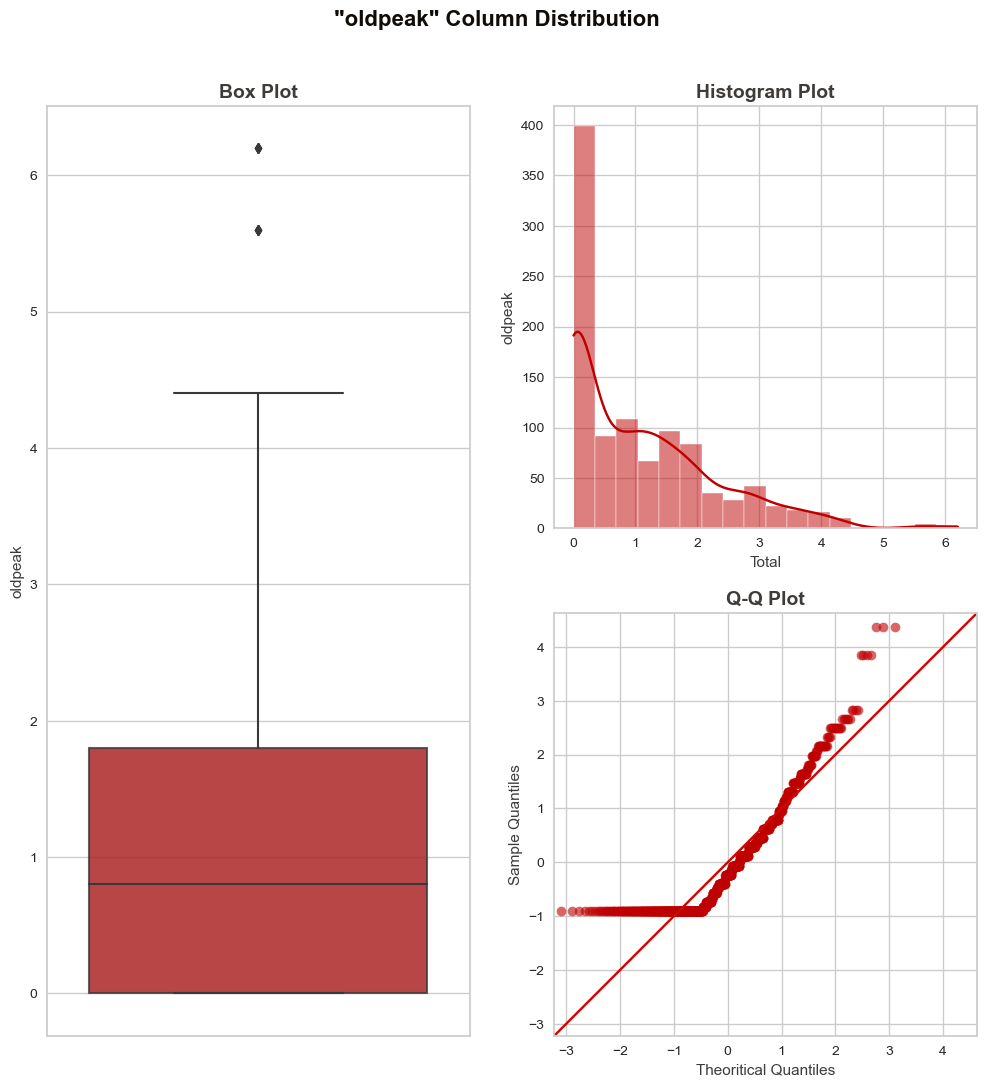

In [25]:
# --- Variable, Color & Plot Size ---
var = 'oldpeak'
color = red_grad[1]
fig=plt.figure(figsize=(12, 12))

# --- Skewness & Kurtosis ---
print('\033[1m'+'.: "oldpeak" Column Skewness & Kurtosis :.'+'\033[0m')
print('*' * 40)
print('Skewness:'+'\033[1m {:.3f}'.format(df[var].skew(axis = 0, skipna = True)))
print('\033[0m'+'Kurtosis:'+'\033[1m {:.3f}'.format(df[var].kurt(axis = 0, skipna = True)))
print('\n')

# --- General Title ---
fig.suptitle('"oldpeak" Column Distribution', fontweight='bold', 
             fontsize=16, fontfamily='sans-serif', color=black_grad[0])
fig.subplots_adjust(top=0.9)

# --- Histogram ---
ax_1=fig.add_subplot(2, 2, 2)
plt.title('Histogram Plot', fontweight='bold', fontsize=14, 
          fontfamily='sans-serif', color=black_grad[1])
sns.histplot(data=df, x=var, kde=True, color=color)
plt.xlabel('Total', fontweight='regular', fontsize=11, 
           fontfamily='sans-serif', color=black_grad[1])
plt.ylabel('oldpeak', fontweight='regular', fontsize=11,
           fontfamily='sans-serif', color=black_grad[1])

# --- Q-Q Plot ---
ax_2=fig.add_subplot(2, 2, 4)
plt.title('Q-Q Plot', fontweight='bold', fontsize=14, fontfamily='sans-serif', 
          color=black_grad[1])
qqplot(df[var], fit=True, line='45', ax=ax_2, markerfacecolor=color,
       markeredgecolor=color, alpha=0.6)
plt.xlabel('Theoritical Quantiles', fontweight='regular', fontsize=11, 
           fontfamily='sans-serif', color=black_grad[1])
plt.ylabel('Sample Quantiles', fontweight='regular', fontsize=11, 
           fontfamily='sans-serif', color=black_grad[1])

# --- Box Plot ---
ax_3=fig.add_subplot(1, 2, 1)
plt.title('Box Plot', fontweight='bold', fontsize=14, 
          fontfamily='sans-serif', color=black_grad[1])
sns.boxplot(data=df, y=var, color=color, boxprops=dict(alpha=0.8), linewidth=1.5)
plt.ylabel('oldpeak', fontweight='regular', fontsize=11, 
           fontfamily='sans-serif', color=black_grad[1])

plt.show()

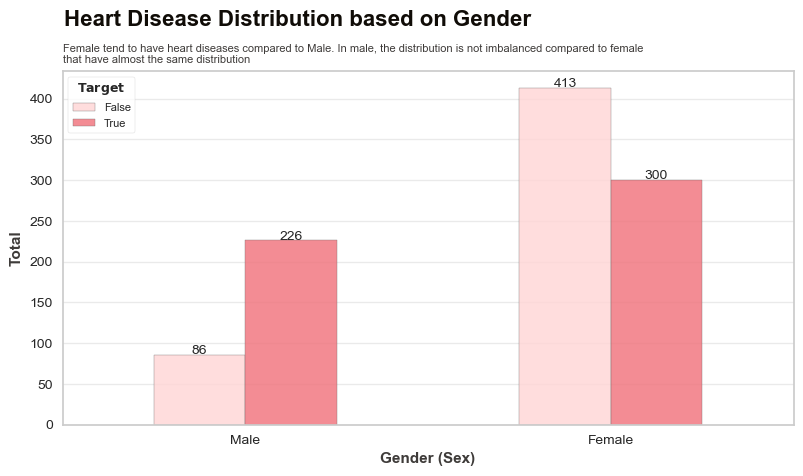

In [26]:
'''
EDA 
Heart Disease Distribution based on Gender

'''
# --- Labels Settings ---
labels = ['False', 'True']
label_gender = np.array([0, 1])
label_gender2 = ['Male', 'Female']

# --- Creating Bar Chart ---
ax = pd.crosstab(df.sex, df.target).plot(kind='bar', figsize=(8, 5), 
                                         color=color_mix[2:4], 
                                         edgecolor=black_grad[2], alpha=0.85)
# --- Bar Chart Settings ---
for rect in ax.patches:
    ax.text (rect.get_x()+rect.get_width()/2, 
             rect.get_height()+1.25,rect.get_height(), 
             horizontalalignment='center', fontsize=10)

plt.suptitle('Heart Disease Distribution based on Gender', fontweight='heavy', 
             x=0.065, y=0.98, ha='left', fontsize='16', fontfamily='sans-serif', 
             color=black_grad[0])
plt.title('Female tend to have heart diseases compared to Male. In male, the distribution is not imbalanced compared to female\nthat have almost the same distribution', 
          fontsize='8', fontfamily='sans-serif', loc='left', color=black_grad[1])
plt.tight_layout(rect=[0, 0.04, 1, 1.025])
plt.xlabel('Gender (Sex)', fontfamily='sans-serif', fontweight='bold', 
           color=black_grad[1])
plt.ylabel('Total', fontfamily='sans-serif', fontweight='bold', 
           color=black_grad[1])
plt.xticks(label_gender, label_gender2, rotation=0)
plt.grid(axis='y', alpha=0.4)
plt.grid(axis='x', alpha=0)
plt.legend(labels=labels, title='$\\bf{Target}$', fontsize='8', 
           title_fontsize='9', loc='upper left', frameon=True);

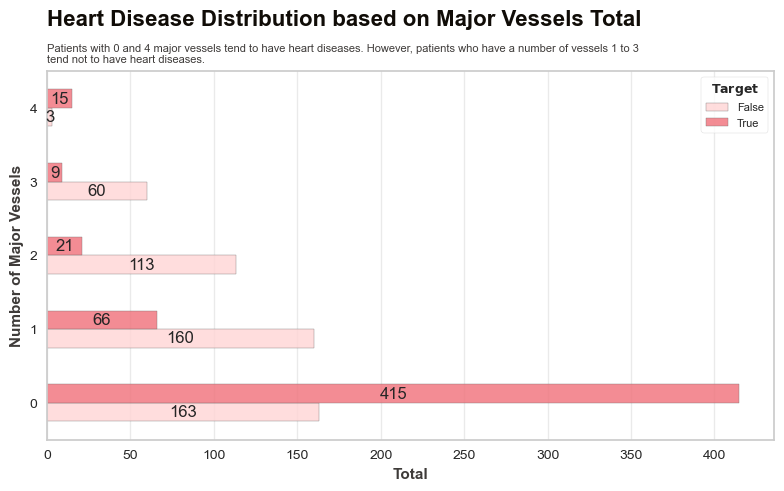

In [27]:
'''
Heart Disease Distribution based on Major Vessels Total
'''
# --- Labels Settings ---
labels = ['False', 'True']

# --- Creating Horizontal Bar Chart ---
ax = pd.crosstab(df.ca, df.target).plot(kind='barh', figsize=(8, 5), 
                                         color=color_mix[2:4],
                                         edgecolor=black_grad[2], alpha=0.85)
# --- Horizontal Bar Chart Settings ---
for rect in ax.patches:
    width, height = rect.get_width(), rect.get_height()
    x, y = rect.get_xy()
    ax.text (x+width/2, y+height/2, '{:.0f}'.format(width), 
             horizontalalignment='center', verticalalignment='center')

plt.suptitle('Heart Disease Distribution based on Major Vessels Total', 
             fontweight='heavy', x=0.069, y=0.98, ha='left', fontsize='16', 
             fontfamily='sans-serif', color=black_grad[0])
plt.title('Patients with 0 and 4 major vessels tend to have heart diseases. However, patients who have a number of vessels 1 to 3\ntend not to have heart diseases.', 
          fontsize='8', fontfamily='sans-serif', loc='left', color=black_grad[1])
plt.tight_layout(rect=[0, 0.04, 1, 1.025])
plt.xlabel('Total', fontfamily='sans-serif', fontweight='bold', color=black_grad[1])
plt.ylabel('Number of Major Vessels', fontfamily='sans-serif', fontweight='bold', 
           color=black_grad[1])
plt.yticks(rotation=0)
plt.grid(axis='x', alpha=0.4)
plt.grid(axis='y', alpha=0)
plt.legend(labels=labels, title='$\\bf{Target}$', fontsize='8', frameon=True,
           title_fontsize='9', loc='upper right');

In [28]:
'''
The following steps are GDP with machine learning.
'''

'\nThe following steps are GDP with machine learning.\n'

In [29]:
# --- Fix Data Types ---
lst=['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
df[lst] = df[lst].astype(object)


'''
Dataset Pre-processing
One-Hot Encoding
'''
# --- Creating Dummy Variables for cp, thal and slope ---
cp = pd.get_dummies(df['cp'], prefix='cp')
thal = pd.get_dummies(df['thal'], prefix='thal')
slope = pd.get_dummies(df['slope'], prefix='slope')

# --- Merge Dummy Variables to Main Data Frame ---
frames = [df, cp, thal, slope]
df = pd.concat(frames, axis = 1)


# --- Display Data Frame ---
df.head().style.background_gradient(cmap='PuRd').hide_index().set_properties(**{'font-family': 'Segoe UI'})

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,cp_0,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
52,1,0,125,212,0,1,168,0,1.000000,2,2,3,0,1,0,0,0,0,0,0,1,0,0,1
53,1,0,140,203,1,0,155,1,3.100000,0,0,3,0,1,0,0,0,0,0,0,1,1,0,0
70,1,0,145,174,0,1,125,1,2.600000,0,0,3,0,1,0,0,0,0,0,0,1,1,0,0
61,1,0,148,203,0,1,161,0,0.000000,2,1,3,0,1,0,0,0,0,0,0,1,0,0,1
62,0,0,138,294,1,1,106,0,1.900000,1,3,2,0,1,0,0,0,0,0,1,0,0,1,0


In [30]:
'''
Dropping Unnecessary Variables 
'''
# --- Drop Unnecessary Variables ---
df = df.drop(columns = ['cp', 'thal', 'slope'])

In [31]:
# --- Display New Data Frame ---
df.head().style.background_gradient(cmap='Reds').hide_index().set_properties(**{'font-family': 'Segoe UI'})

age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,target,cp_0,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
52,1,125,212,0,1,168,0,1.000000,2,0,1,0,0,0,0,0,0,1,0,0,1
53,1,140,203,1,0,155,1,3.100000,0,0,1,0,0,0,0,0,0,1,1,0,0
70,1,145,174,0,1,125,1,2.600000,0,0,1,0,0,0,0,0,0,1,1,0,0
61,1,148,203,0,1,161,0,0.000000,1,0,1,0,0,0,0,0,0,1,0,0,1
62,0,138,294,1,1,106,0,1.900000,3,0,1,0,0,0,0,0,1,0,0,1,0


In [32]:
'''
Features Separating 
'''
# --- Seperating Dependent Features ---
x = df.drop(['target'], axis=1)
y = df['target']



'''
Data Normalization
'''
# --- Data Normalization using Min-Max Method ---
x = MinMaxScaler().fit_transform(x)



'''
Splitting the Dataset 
'''
# --- Splitting Dataset into 80:20 ---
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4)


'''
Machine Learning Training on Continuous Features
===========================================================================================================================
'''


'''
Logistic Regression
'''
# --- Applying Logistic Regression ---
LRclassifier = LogisticRegression(max_iter=1000, random_state=1, solver='liblinear', penalty='l1')
LRclassifier.fit(x_train, y_train)
y_pred_LR = LRclassifier.predict(x_test)

# --- LR Accuracy ---
LRAcc = accuracy_score(y_pred_LR, y_test)
print('.:. Logistic Regression Accuracy:'+'\033[1m {:.2f}%'.format(LRAcc*100)+' .:.')



'''
K-Nearest Neighbour (KNN)
'''
# --- Applying KNN ---
KNNClassifier = KNeighborsClassifier(n_neighbors=3)
KNNClassifier.fit(x_train, y_train)
y_pred_KNN = KNNClassifier.predict(x_test)

# --- KNN Accuracy ---
KNNAcc = accuracy_score(y_pred_KNN, y_test)
print('.:. K-Nearest Neighbour Accuracy:'+'\033[1m {:.2f}%'.format(KNNAcc*100)+' .:.')

# ------------------------------------------------------------------------------------------------------------------------

'''
Support Vector Machine (SVM)
'''
# --- Applying SVM ---
SVMclassifier = SVC(kernel='linear', max_iter=1000, C=10, probability=True)
SVMclassifier.fit(x_train, y_train)
y_pred_SVM = SVMclassifier.predict(x_test)

# --- SVM Accuracy ---
SVMAcc = accuracy_score(y_pred_SVM, y_test)
print('.:. Support Vector Machine Accuracy:'+'\033[1m {:.2f}%'.format(SVMAcc*100)+' .:.')

# ------------------------------------------------------------------------------------------------------------------------

'''
Gaussian Naive Bayes
'''
# --- Applying Gaussian NB ---
GNBclassifier = GaussianNB(var_smoothing=0.1)
GNBclassifier.fit(x_train, y_train)
y_pred_GNB = GNBclassifier.predict(x_test)

# --- GNB Accuracy ---
GNBAcc = accuracy_score(y_pred_GNB, y_test)
print('.:. Gaussian Naive Bayes Accuracy:'+'\033[1m {:.2f}%'.format(GNBAcc*100)+' .:.')

# ------------------------------------------------------------------------------------------------------------------------

'''
Decision Tree
'''
# --- Applying Decision Tree ---
DTCclassifier = DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, criterion='entropy', min_samples_split=5,
                                       splitter='random', random_state=1)
DTCclassifier.fit(x_train, y_train)
y_pred_DTC = DTCclassifier.predict(x_test)

# --- Decision Tree Accuracy ---
DTCAcc = accuracy_score(y_pred_DTC, y_test)
print('.:. Decision Tree Accuracy:'+'\033[1m {:.2f}%'.format(DTCAcc*100)+' .:.')
# ------------------------------------------------------------------------------------------------------------------------

'''
Random Forest
'''
# --- Applying Random Forest ---
RFclassifier = RandomForestClassifier(n_estimators=1000, random_state=1, max_leaf_nodes=20, min_samples_split=15)
RFclassifier.fit(x_train, y_train)
y_pred_RF = RFclassifier.predict(x_test)

# --- Random Forest Accuracy ---
RFAcc = accuracy_score(y_pred_RF, y_test)
print('.:. Random Forest Accuracy:'+'\033[1m {:.2f}%'.format(RFAcc*100)+' .:.')

# ------------------------------------------------------------------------------------------------------------------------

'''
Gradient Boosting
'''
# --- Applying Gradient Boosting ---
GBclassifier = GradientBoostingClassifier(random_state=1, n_estimators=100, max_leaf_nodes=3, loss='exponential', 
                                          min_samples_leaf=20)
GBclassifier.fit(x_train, y_train)
y_pred_GB = GBclassifier.predict(x_test)

# --- Gradient Boosting Accuracy ---
GBAcc = accuracy_score(y_pred_GB, y_test)
print('.:. Gradient Boosting Accuracy:'+'\033[1m {:.2f}%'.format(GBAcc*100)+' .:.')

# =====================================================================================================================

'''
Model Comparison
'''
# --- Create Accuracy Comparison Table ---
compare = pd.DataFrame({'Model': ['Logistic Regression', 'K-Nearest Neighbour', 'Support Vector Machine', 
                                  'Gaussian Naive Bayes', 'Decision Tree', 'Random Forest', 'Gradient Boosting'
                                  ], 
                        'Accuracy': [LRAcc*100, KNNAcc*100, SVMAcc*100, GNBAcc*100, DTCAcc*100, RFAcc*100, GBAcc*100, 
                                     ]})

# --- Create Accuracy Comparison Table ---
print("\n Model Performance on noise data when e=0.1 ")
compare.sort_values(by='Accuracy', ascending=False).style.background_gradient(cmap='PuRd').hide_index().set_properties(**{'font-family': 'Segoe UI'})

.:. Logistic Regression Accuracy: 83.90% .:.
.:. K-Nearest Neighbour Accuracy: 95.61% .:.
.:. Support Vector Machine Accuracy: 83.90% .:.
.:. Gaussian Naive Bayes Accuracy: 82.44% .:.
.:. Decision Tree Accuracy: 83.90% .:.
.:. Random Forest Accuracy: 88.78% .:.
.:. Gradient Boosting Accuracy: 86.83% .:.

 Model Performance on noise data when e=0.1 


Model,Accuracy
K-Nearest Neighbour,95.609756
Random Forest,88.780488
Gradient Boosting,86.829268
Logistic Regression,83.902439
Support Vector Machine,83.902439
Decision Tree,83.902439
Gaussian Naive Bayes,82.439024
